# Tutorial

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from core.input import input_format
from core.masking import create_padding_mask
from core.astromer import get_ASTROMER, get_FINETUNING, train
from core.data  import (create_dataset, 
                        standardize,
                        load_records)

# This tutorial runs only in early mode. For the optimized code use train.py
# OTHERWISE you can comment the next line and reset the kernel before the finetuning
tf.config.run_functions_eagerly(True)

%load_ext autoreload
%autoreload 2

In [2]:
source = './data/raw_data/MACHO/' # lightcurves folder
metadata = 'data/raw_data/MACHO/MACHO_dataset.dat' # metadata file
target = 'data/records/macho/' # where records will be stored

### Metadata frame sample

In [3]:
meta_sample = pd.read_csv(metadata).sample(1)
meta_sample

,Unnamed: 0,Class,N,Path,Band
763,763,EB,1212,LCs/lc_1_4291_560_B_mjd.dat,B


### Lightcurve frame sample

In [4]:
lc_df = pd.read_csv(os.path.join(source,  meta_sample['Path'].values[0]))
lc_df.head()

,mjd,mag,errmag
0,48823.477419,-6.212,0.117
1,48823.487014,-6.264,0.100
2,48823.496759,-5.969,0.152
3,48824.458206,-6.210,0.036
4,48824.467697,-6.199,0.030


### From .csv to .record 

In [5]:
# create_dataset(source, metadata, target, max_lcs_per_record=1000)

### Loading Data

In [10]:
batch_size = 256
input_len = 200

In [11]:
# Loading data

train_batches = load_records(os.path.join(target, 'train'), 
                             batch_size, 
                             input_len=input_len,
                             balanced=True)
valid_batches = load_records(os.path.join(target, 'val'), 
                             batch_size, 
                             input_len=input_len,
                             balanced=True)
test_batches = load_records(os.path.join(target, 'test'), 
                             batch_size, 
                             input_len=input_len)

### Visualizing Records

In [36]:
input_len = 200 # maximum lightcurve length
batch_size = 256
dataset = load_records(target+'/train', batch_size=batch_size, input_len=input_len)

None


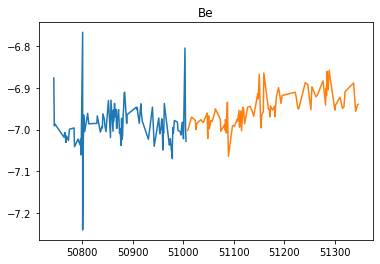

In [38]:
n = 0
fig, axes = plt.subplots(1,1)
for batch in train_batches:
    mask_1 = create_padding_mask(batch['serie_1'], batch['steps_1']-1)
    mask_2 = create_padding_mask(batch['serie_2'], batch['steps_2']-1)

    serie_1 = tf.boolean_mask(batch['serie_1'][n], tf.logical_not(mask_1[n]))
    serie_2 = tf.boolean_mask(batch['serie_2'][n], tf.logical_not(mask_2[n]))

    y = batch['label'][n]
    objects = pd.read_csv(os.path.join(target, 'objects.csv'))
    cls_label = objects.iloc[int(y)]['label']

    axes.plot(serie_1[:, 0], serie_1[:, 1])
    axes.plot(serie_2[:, 0], serie_2[:, 1])
    axes.set_title(cls_label)
    break

## ASTROMER

### Input Layer

(256, 203, 1)
(256, 1, 203, 203)
(256, 203, 1)
(256, 1, 203, 203)
(256, 203, 1)
(256, 1, 203, 203)
(256, 203, 1)
(256, 1, 203, 203)
(24, 203, 1)
(24, 1, 203, 203)


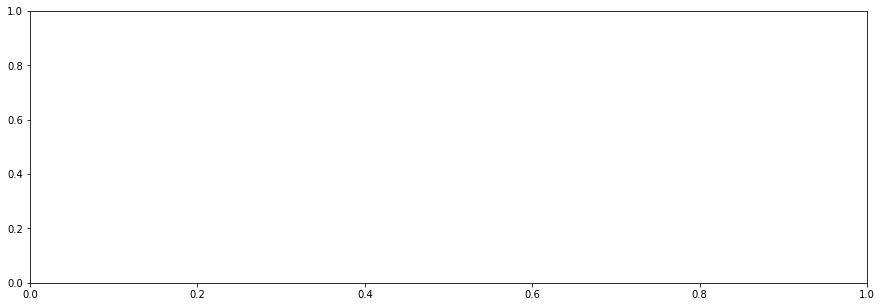

In [15]:
fig, axes = plt.subplots(1,1, figsize=(15,5))
for batch in train_batches:
    n = 0
    inputs, targets = input_format(batch)
    print(inputs['values'].shape)
    print(inputs['mask'].shape)
    continue
    magnitudes = inputs['values'][n][1:, 0]
    times = inputs['times'][n][1:, 0]
#     print(times)
    mask = targets['x_mask'][n]
    
    x = tf.boolean_mask(times, mask)
    y = tf.boolean_mask(magnitudes, mask)
    
    x_original = tf.slice(batch['serie_1'], [0,0,0],[-1,-1,1])
    x_original = x_original - tf.expand_dims(tf.reduce_min(x_original, 1), 2)
    y_original = tf.slice(batch['serie_1'], [0,0,1],[-1,-1,1])
    y_original = standardize(y_original)
    
    
    
    dt = [[[1.]]]# tf.expand_dims(tf.reduce_mean(x_original, 1), 2)
    last = tf.slice(x_original, [0,tf.shape(x_original)[1]-1,0], [-1, 1,-1])
    
    x_2_original = tf.slice(batch['serie_2'], [0,0,0],[-1,-1,1])
    x_2_original = x_2_original - tf.expand_dims(tf.reduce_min(x_2_original, 1), 2)
    x_2_original = x_2_original + last + dt
    
    y_2_original = tf.slice(batch['serie_2'], [0,0,1],[-1,-1,1])
    y_2_original = standardize(y_2_original)

    axes.plot(x_original[n], y_original[n], label='Original', color='black')
    axes.plot(x_2_original[n], y_2_original[n], color='black')
    axes.plot(x, y, linestyle='', marker='o',label='Input', color='red')
    axes.legend()
    
    if targets['y_true'][n][:, 0].numpy() == 1:
        title = 'Random Next Portion'
    else:
        title = 'No Next Random Portion'
    axes.set_title(title)
    break

# Training

In [34]:
astromer = get_ASTROMER()

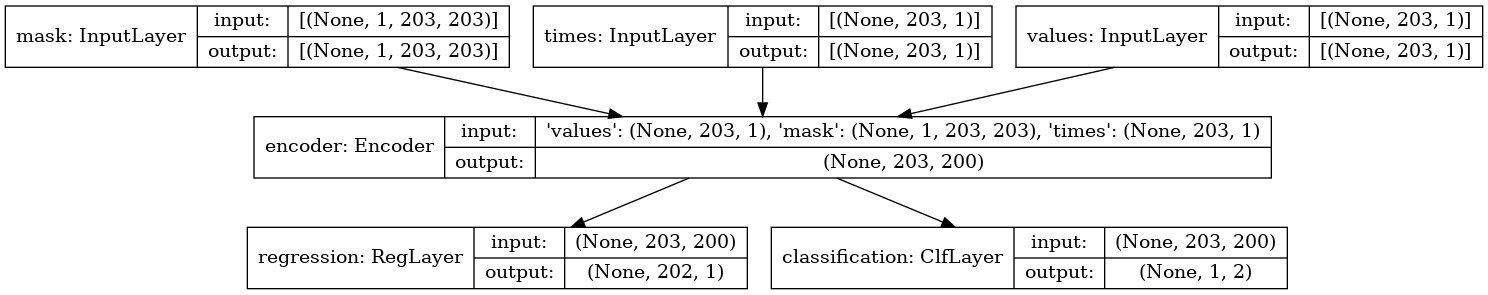

In [11]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [12]:
train(astromer, train_batches, valid_batches, epochs=2)

train: 315it [01:55,  2.73it/s]
validation: 157it [00:50,  3.12it/s]


tf.Tensor(94.8064, shape=(), dtype=float32)


train: 315it [02:00,  2.62it/s]
validation: 157it [00:46,  3.40it/s]

tf.Tensor(7.8247166, shape=(), dtype=float32)


# FINETUNNING

In [13]:
astromer = get_ASTROMER()

In [14]:
astromer.load_weights('./experiments/test/weights')

In [15]:
ft_model = get_FINETUNING(astromer, num_cls=10)

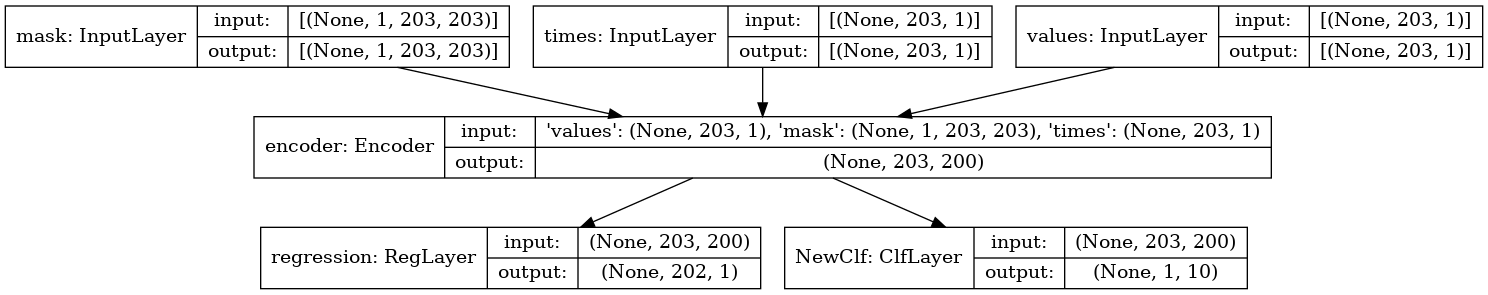

In [16]:
tf.keras.utils.plot_model(ft_model, show_shapes=True)

In [17]:
train(ft_model, train_batches, valid_batches, epochs=2, num_cls=10)

train: 315it [02:01,  2.58it/s]
validation: 157it [00:48,  3.22it/s]


tf.Tensor(3.4514093, shape=(), dtype=float32)


train: 315it [01:54,  2.75it/s]
validation: 157it [00:45,  3.46it/s]
